# Implementation of BiCP2P on total VHI data for Karnataka


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Marking vhi**

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D, TimeDistributed, Conv2D, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#loading VHI data
VHI_train = np.loadtxt("/content/drive/MyDrive/Saved indices/VHI_train.txt").reshape(91,256,256)
VHI_test = np.loadtxt("/content/drive/MyDrive/Saved indices/VHI_test.txt").reshape(22,256,256)

In [ ]:
np.max(VHI_train), np.min(VHI_train), np.max(VHI_test),np.min(VHI_test)

(100.0, 3.71706425194148, 98.23626825409147, 14.116263109324514)

In [ ]:
import numpy as np
from PIL import Image


_errstr = "Mode is unknown or incompatible with input array shape."


def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)
def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


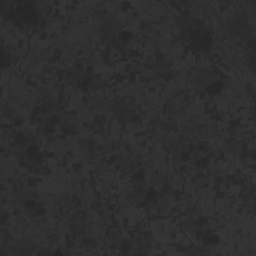

(57.244876871537436, 37.648232105757145)

In [ ]:
mat = VHI_train[1]
import scipy.misc
im = toimage(mat, cmin=np.min(mat), cmax=np.max(mat)).save('outfile.jpg')
# Creates PIL image
img = Image.fromarray(mat, 'L')
img = np.asarray(img)
cv2.imwrite("img.jpg",img)
cv2_imshow(mat)
np.max(mat),np.min(mat)

In [ ]:
mat.min()

37.648232105757145

In [ ]:
mat = VHI_train[1]
mat

array([[44.42890781, 44.47376745, 44.75099827, ..., 42.21662731,
        42.60146257, 43.02879509],
       [44.53900384, 44.7052315 , 44.65275131, ..., 42.81122895,
        42.07641002, 42.74622958],
       [43.28842026, 43.20460193, 43.94442775, ..., 44.96683819,
        43.33795434, 44.37515204],
       ...,
       [41.49083725, 41.72006554, 41.96493757, ..., 48.53326028,
        48.69863785, 51.69391103],
       [41.1474503 , 41.35452799, 41.78580947, ..., 49.48817207,
        48.79259569, 48.82038001],
       [41.35707496, 41.27984568, 41.71671184, ..., 49.26656906,
        47.36760854, 46.14525987]])

In [ ]:
np.min(mat)

37.648232105757145

In [ ]:
a = bytescale(VHI_train[1], cmin=0, cmax=255)
a.min(), a.max(), np.unique(a)

(38,
 57,
 array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57], dtype=uint8))

In [ ]:
img = cv2.imread('/content/outfile.jpg')


np.max(img)

247

In [ ]:
print(mat[0][1])
if (mat[0][1] <40) | (mat[0][1]>30):
  mat[0][1] = 1
mat[0][1]

44.473767445378755


1.0

In [ ]:
for i in range(mat.shape[0]):
  for j in range(mat.shape[1]):
    #print(mat[i][j])
    if (mat[i][j])> 40:                             #Normal
      mat[i][j] = 255
    elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      mat[i][j]= 64
    elif (mat[i][j]<30) &(mat[i][j]>20):              # Moderate drought
      mat[i][j] = 16
    elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      mat[i][j] = 4
    elif (mat[i][j])<10:                              # Extreme  drought
      mat[i][j]= 0
mat

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [ ]:
np.unique(mat)

array([ 64., 255.])

In [ ]:
np.unique(a)

array([ 40,  64, 255], dtype=uint8)

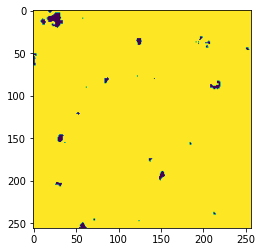

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mat)
plt.imsave("dis.jpg", mat)

In [ ]:
cv2.imwrite("discrete.jpg",mat)

True

# Implementing pix2pix using arrays directly

In [ ]:
import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D, TimeDistributed, Conv2D, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#loading VHI data
VHI_train = np.loadtxt("/Users/Jyoti_Shukla//Documents/Jyoti/Karnataka Dataset/Padded_Train_total_AVHRR_data_1981_2022.txt")
VHI_test = np.loadtxt("/Users/Jyoti_Shukla//Documents/Jyoti/Karnataka Dataset/Padded_Test_total_AVHRR_data_1981_2022.txt")
VHI_train = VHI_train.reshape(2070,192,128)
VHI_test = VHI_test.reshape(53,192,128)
print("VHI_ train_shape :", VHI_train.shape)
print("\n VHI_test_shape: ", VHI_test.shape)
np.max(VHI_train), np.min(VHI_train), np.max(VHI_test),np.min(VHI_test)

VHI_ train_shape : (2070, 192, 128)

 VHI_test_shape:  (53, 192, 128)


(100.0, 0.0, 100.0, 0.0)

In [ ]:
#loading VHI data
VHI_train = np.loadtxt("/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/Padded_Train_total_AVHRR_data_1981_2022.txt")
VHI_test = np.loadtxt("/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/Padded_Test_total_AVHRR_data_1981_2022.txt")
VHI_train = VHI_train.reshape(2070,192,128)
VHI_test = VHI_test.reshape(53,192,128)
print("VHI_ train_shape :", VHI_train.shape)
print("\n VHI_test_shape: ", VHI_test.shape)
np.max(VHI_train), np.min(VHI_train), np.max(VHI_test),np.min(VHI_test)

VHI_ train_shape : (2070, 192, 128)

 VHI_test_shape:  (53, 192, 128)


(100.0, 0.0, 100.0, 0.0)

# **PIX2PIX USING ARRAY**

In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
import numpy as np
import tensorflow as tf
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape= (190,124,)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	# e6 = define_encoder_block(e5, 512)
	# e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
	b = Activation('relu')(b)
	# decoder model
	# d1 = decoder_block(b, e7, 512)
	# d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(b, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('sigmoid')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	# opt = SGD(learning_rate=0.0002)
	huber_loss = tf.keras.losses.Huber(delta=0.5)
	model.compile(loss=['mse', huber_loss], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = np.load(filename)
	# unpack arrays
	x1, x2 = data['x'], data['y']
	X1, X2 = x1[:], x2[:]
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	#print(ix)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape[1], patch_shape[2], 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape[1], patch_shape[2], 1))
	return X, y

In [ ]:
patch = np.ones((1,1,1))
patch

array([[[1.]]])

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples =3):
  #select a sample of input images
  patch = np.ones((1,1,1))
  [X_realA, X_realB],_ = generate_real_samples(dataset, n_samples,patch.shape)
  #generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, patch.shape)
  #scale all pixels from [-1,-1] to [0,1]
  # X_realA = (X_realA +1)/ 2.0
  # X_realB = (X_realB +1)/2.0
  # X_fakeB = (X_fakeB +1)/2.0
  for i in range(n_samples):
    #name = '/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/generated_image_'+str(step+1) + str(i)+'.jpg'
    # name = '/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_4_bcdunet/generated_image_'+str(step+1) + str(i)+'.jpg'
    name = '/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/generated_image_'+str(step+1) + str(i)+'.jpg'
    matplotlib.image.imsave(name, X_fakeB[i].reshape(192,128))
  #plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i].reshape(192,128))
    # pyplot.title("Original Images")
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+ n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i].reshape(192,128))
    # pyplot.title("Generated Images")
  #plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+ n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i].reshape(192,128))
    # pyplot.title("Expected Images")
  # save plot to file
  #filename1 = '/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/plot_%06d.png' % (step+1)
  #filename1 = '/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_4_bcdunet/plot_%06d.png' % (step+1)
  filename1 = '/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  #filename2 = '/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/model_%06d.h5' % (step+1)
  #filename2 = '/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_4_bcdunet/model_%06d.h5' % (step+1)
  filename2 = '/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' %(filename1, filename2))

In [ ]:
dataset = load_real_samples("/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_train_AVHRR_data.npz")
[X_realA, X_realB],y_real = generate_real_samples(dataset, 3,patch.shape)
X_realA.shape

(3, 192, 128, 1)

In [ ]:
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, patch.shape)
X_fakeB.shape, y_fake.shape

((3, 192, 128, 1), (3, 1, 1, 1))

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	disc_loss =[]
	disc_loss_real =[]
	gen_loss =[]
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		disc_loss.append(d_loss2)
		disc_loss_real.append(d_loss1)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		gen_loss.append(g_loss)
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % 1000 == 0:
			summarize_performance(i, g_model, dataset)
	return disc_loss_real, disc_loss, gen_loss

In [ ]:
# load image data
dataset = load_real_samples("/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_train_total_AVHRR_data.npz")
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

Loaded (2069, 192, 128, 1) (2069, 192, 128, 1)


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
tf.keras.utils.plot_model(g_model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
d_model.output_shape[2]
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [ ]:
trainA, trainB = dataset
bat_per_epo = int(len(trainA) / 1)
	# calculate the number of training iterations
n_steps = bat_per_epo * 10
n_patch = d_model.output_shape
for i in range(150):
  [X_realA, X_realB], y_real = generate_real_samples(dataset, 1, n_patch)
  X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
  d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
  d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
  g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
  print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
  if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)


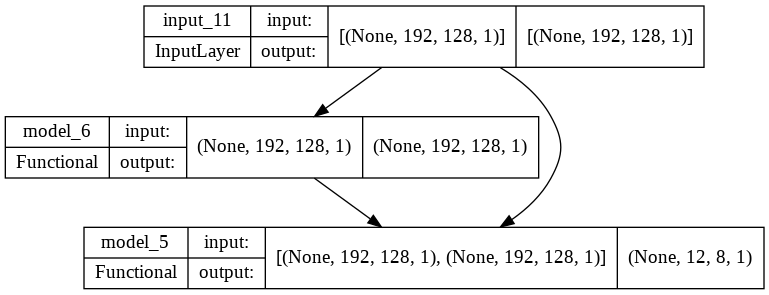

In [ ]:
tf.keras.utils.plot_model(gan_model, show_shapes=True)

In [ ]:
image_shape = dataset[0].shape[1:]
image_shape

(192, 128, 1)

Loaded (2069, 192, 128, 1) (2069, 192, 128, 1)


C:\Users\Jyoti_Shukla\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
>15701, d1[0.354] d2[0.348] g[0.362]
>15702, d1[0.330] d2[0.368] g[0.409]
>15703, d1[0.345] d2[0.350] g[0.386]
>15704, d1[0.356] d2[0.340] g[0.364]
>15705, d1[0.363] d2[0.353] g[0.348]
>15706, d1[0.363] d2[0.340] g[0.359]
>15707, d1[0.360] d2[0.340] g[0.361]
>15708, d1[0.349] d2[0.352] g[0.367]
>15709, d1[0.330] d2[0.376] g[0.400]
>15710, d1[0.363] d2[0.341] g[0.334]
>15711, d1[0.364] d2[0.340] g[0.336]
>15712, d1[0.365] d2[0.339] g[0.322]
>15713, d1[0.254] d2[0.331] g[1.616]
>15714, d1[0.347] d2[0.348] g[0.389]
>15715, d1[0.363] d2[0.355] g[0.342]
>15716, d1[0.346] d2[0.348] g[0.377]
>15717, d1[0.362] d2[0.333] g[0.351]
>15718, d1[0.363] d2[0.334] g[0.340]
>15719, d1[0.348] d2[0.345] g[0.366]
>15720, d1[0.330] d2[0.364] g[0.374]
>15721, d1[0.310] d2[0.387] g[0.381]
>15722, d1[0.322] d2[0.366] g[0.391]
>15723, d1[0.341] d2[0.380] g[0.362]
>15724, d1[0.359] d2[0.342] g[0.364]
>15725, d1[0.298] d2[0.426] g[0.400]
>15726, d1[0.354] d2[0.3

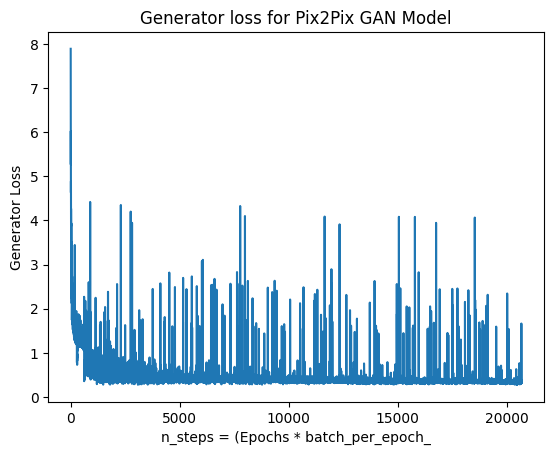

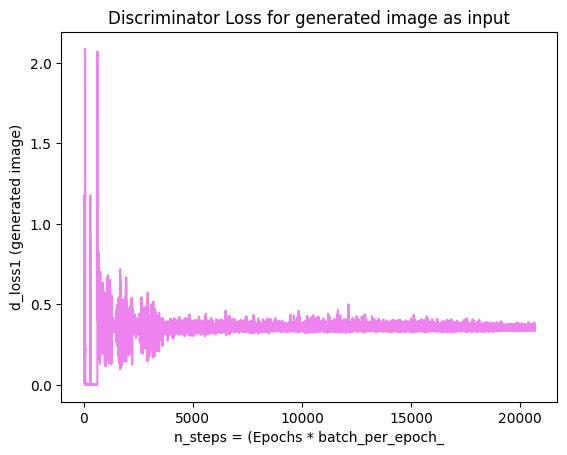

Text(0.5, 1.0, 'Discriminator Loss for real image as input')

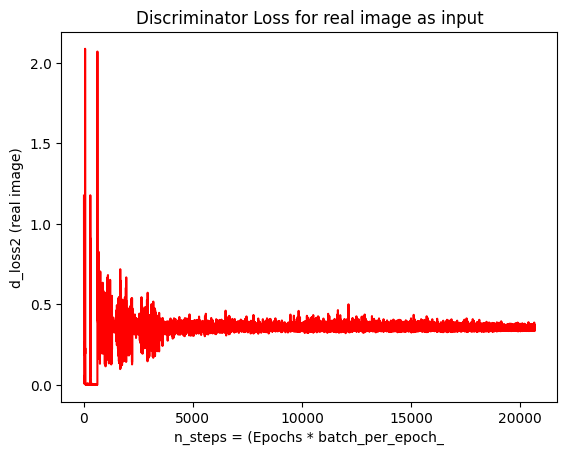

In [ ]:
# load image data
#dataset = load_real_samples("/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_train_AVHRR_data.npz")
#dataset = load_real_samples("/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_train_total_AVHRR_data.npz")
dataset = load_real_samples("/Users/Jyoti_Shukla/Documents/Jyoti/Karnataka Dataset/paired_padded_arrays_train_total_AVHRR_data.npz")
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
d_model.summary()
g_model.summary()
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
disc_loss_real, disc_loss_gen, gen_loss = train(d_model, g_model, gan_model, dataset)
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input")

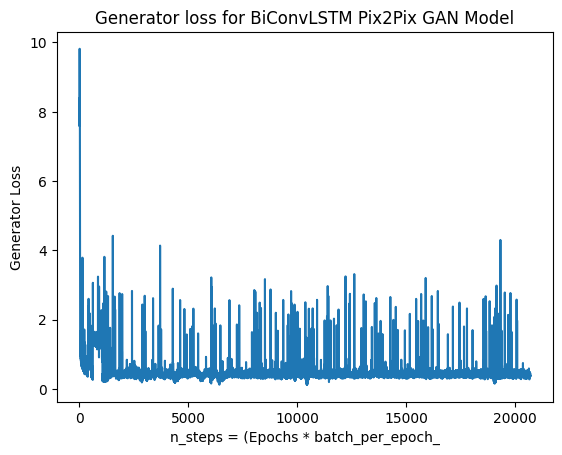

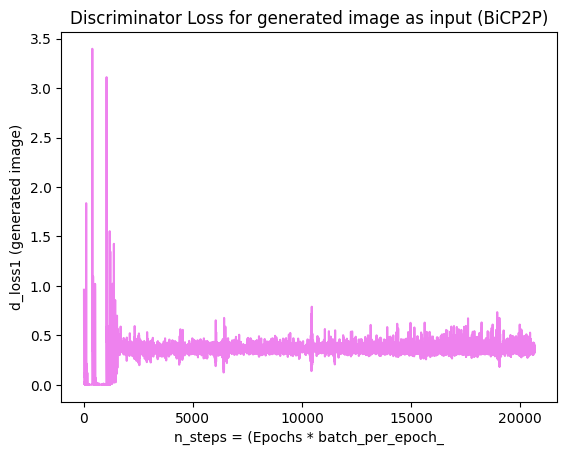

Text(0.5, 1.0, 'Discriminator Loss for real image as input (BiCP2P)')

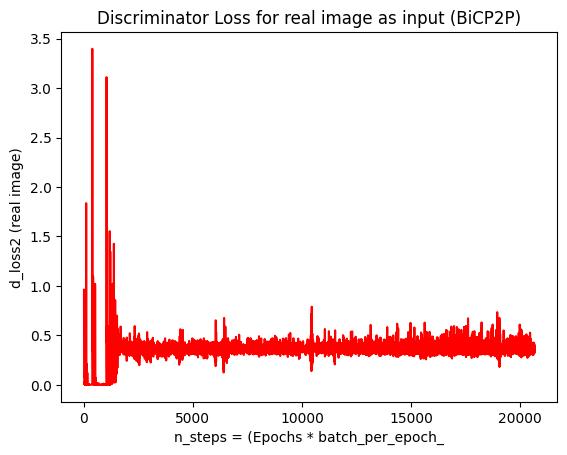

In [ ]:
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("Generator Loss")
plt.title("Generator loss for BiConvLSTM Pix2Pix GAN Model")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input (BiCP2P)")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input (BiCP2P)")

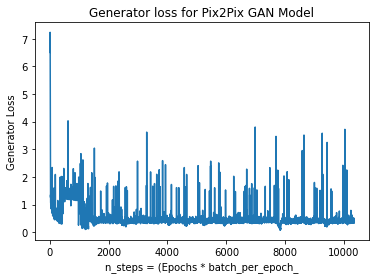

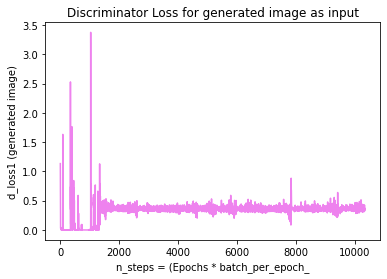

Text(0.5, 1.0, 'Discriminator Loss for real image as input')

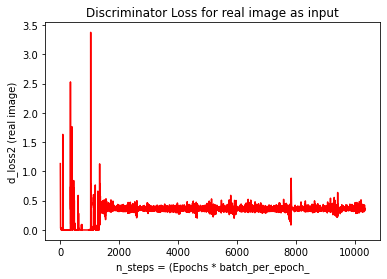

In [ ]:
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("n_steps = (Epochs * batch_per_epoch_")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input")

In [ ]:
# unscaling values
def unscale(mat, VHI_test):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(VHI_test)
  unscaled = scaler.inverse_transform(mat.reshape(192,128))
  return unscaled

In [ ]:
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if  mat[i][j] >80:
        mat[i][j] = 255
      # elif (mat[i][j]<80) &(mat[i][j] >70):             # Abnormally Dry
      #   mat[i][j]= 128
      elif (mat[i][j]<80) &(mat[i][j] >60):             # Abnormally Dry
        mat[i][j]= 128
      # elif (mat[i][j]<60) &(mat[i][j] >50):             # Abnormally Dry
      #   mat[i][j]= 64
      elif (mat[i][j]<60) &(mat[i][j] >40):             # Abnormally Dry
        mat[i][j]= 64
      # elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      #   mat[i][j]= 16
      elif (mat[i][j]<40) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = 32
      # elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      #   mat[i][j] = 4
      elif (mat[i][j])<20:                              # Extreme  drought
        mat[i][j]= 0
  return mat

Loaded (52, 192, 128, 1) (52, 192, 128, 1)
[1]
The generated image array through gan is: 
 [[1.0162015e-01 5.1396117e-02 5.9087209e-02 ... 1.6595252e-03
  1.9379586e-03 1.3068927e-02]
 [9.4795726e-02 4.3311175e-03 4.0552723e-03 ... 1.3416354e-04
  1.8176266e-04 3.1229611e-03]
 [6.5073580e-03 9.6667046e-03 1.2244498e-02 ... 1.4138721e-04
  4.8911439e-05 1.4720227e-03]
 ...
 [3.8998656e-02 8.8361707e-03 8.7668421e-03 ... 5.2886422e-05
  4.3427946e-05 1.2972640e-03]
 [1.8259738e-02 1.2003582e-02 2.0032199e-03 ... 2.3795679e-05
  3.6799429e-05 8.0661458e-04]
 [1.8155916e-01 3.8902130e-02 2.9990293e-02 ... 3.9207638e-04
  3.4048629e-04 7.8304037e-03]]

 The expected output was: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


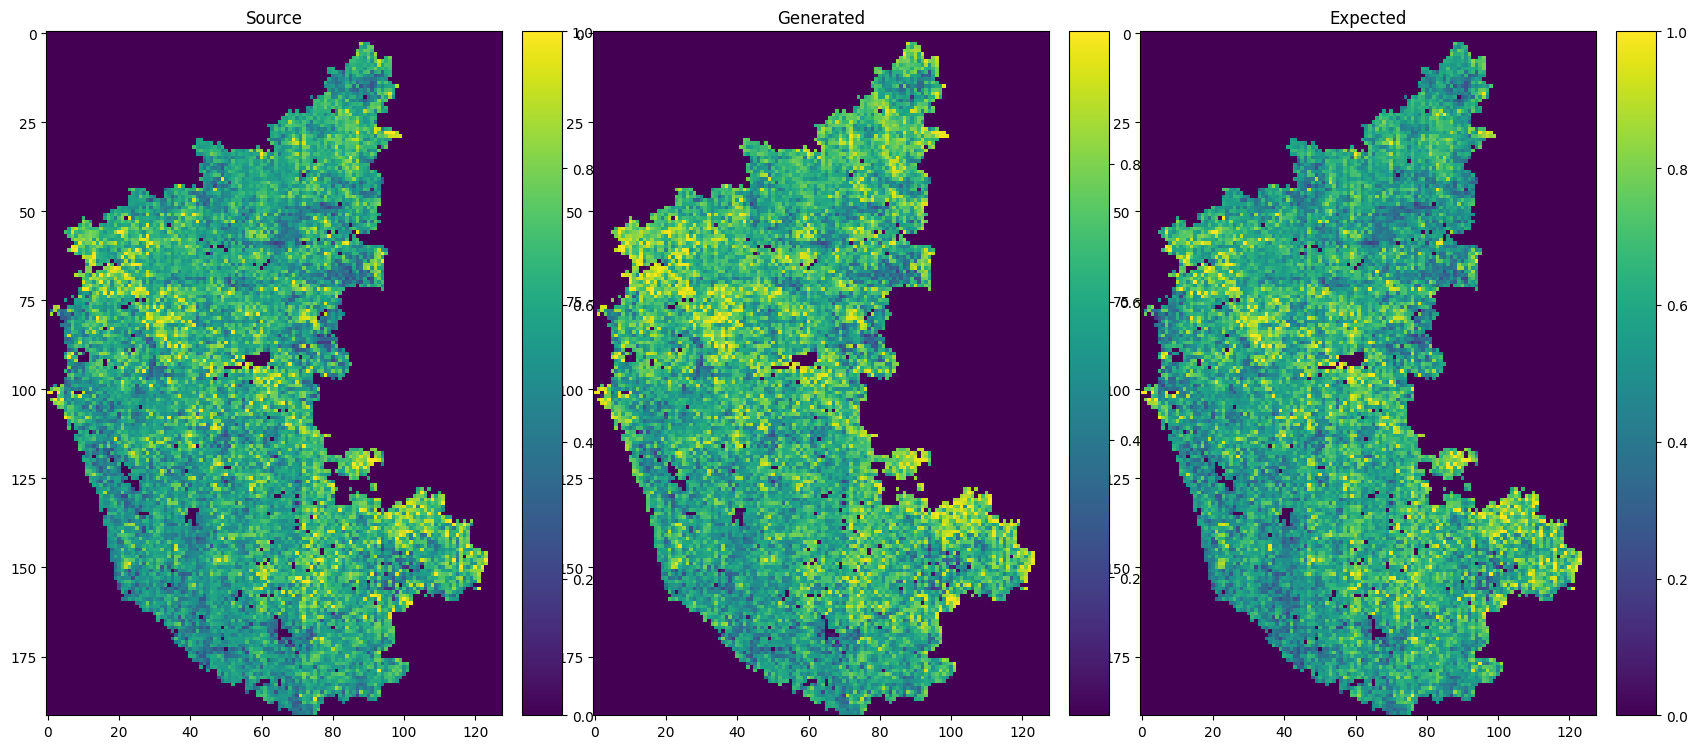


 Unique values of image under test:
 [  0.  32.  64. 128. 255.]
 Unique values of predicted image:
 [  0.  32.  64. 128. 255.] 


 After color-coding the output looks like:



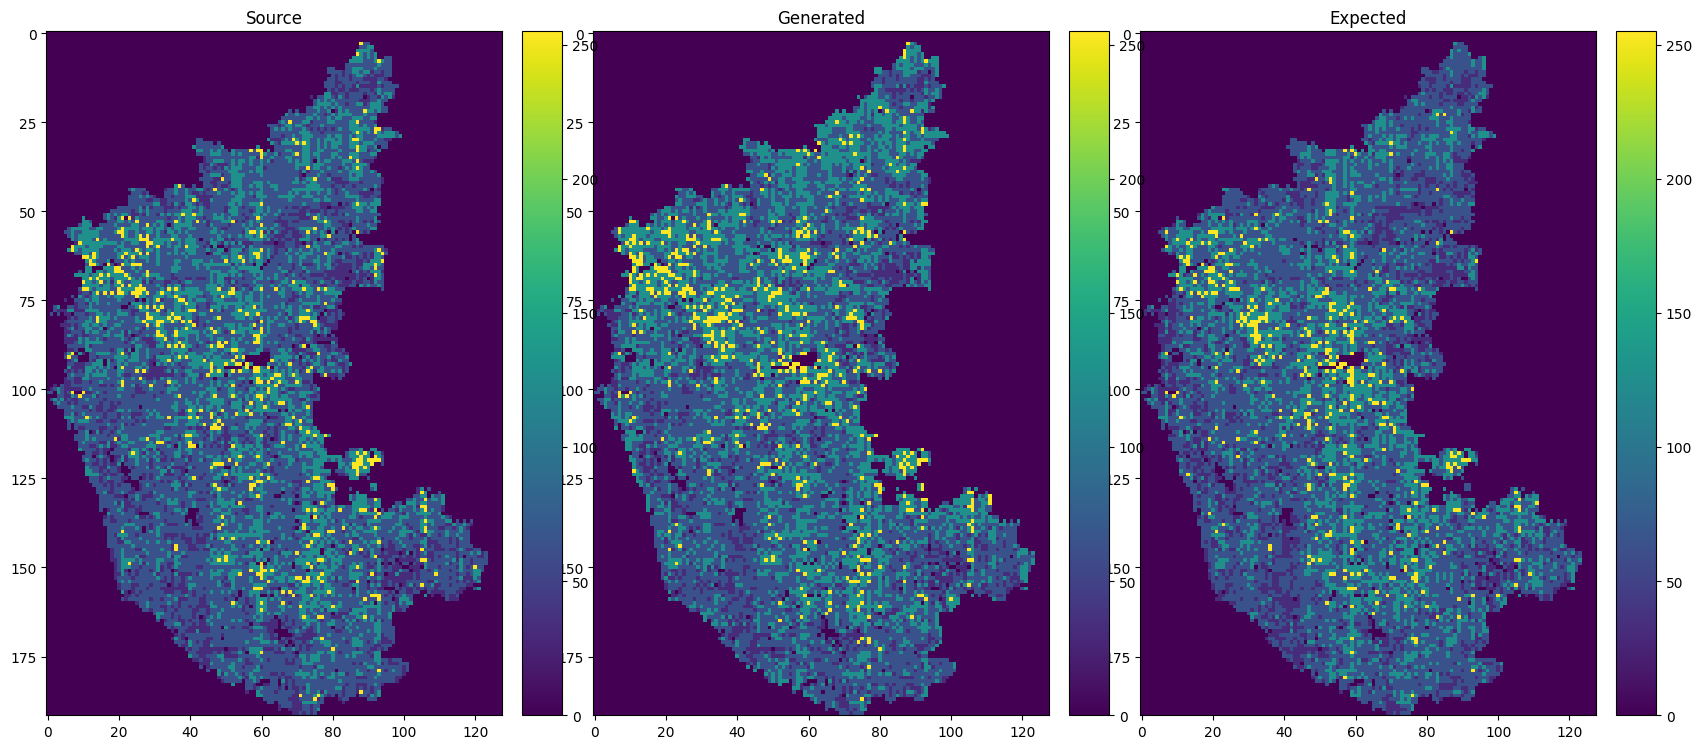

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

#plot source, generated and target images

# def plot_images(src_img, gen_img, tar_img):
#   images = vstack((src_img,gen_img, tar_img))
#   #scale from [-1,1] to [0,1]
#   #images = (images +1)/2.0
#   titles = ['Source','Generated','Expected']
#   #plot images row by
#   # matplotlib.image.imsave("Generated_img.jpg",images[1])
#   # matplotlib.image.imsave("Target_img.jpg",images[2])
#   for i in range(len(images)):
#     #define subplot
#     pyplot.subplot(1,3,1+i)
#     #turn off acis
#     pyplot.axis('off')
#     #plot raw pixel data
#     pyplot.imshow(images[i].reshape(512,512))
#     #show title
#     pyplot.title(titles[i])
#   pyplot.show()
# plot source, generated and target images

def plot_images(src_img, gen_img, tar_img):
  #images = [src_img,gen_img, tar_img]
  images = vstack((src_img,gen_img, tar_img))
  #scale from [-1,1] to [0,1]
  #images = (images +1)/2.0
  titles = ['Source','Generated','Expected']
  #plot images row by
  # matplotlib.image.imsave("Generated_img.jpg",images[1])
  # matplotlib.image.imsave("Target_img.jpg",images[2])
  f, axarr = plt.subplots(1,3, figsize=(20,20))
  for i in range(len(images)):
    #define subplot
    pos = axarr[i].imshow(images[i].reshape(192,128), interpolation = 'None')
    cax = f.add_axes([axarr[i].get_position().x1+0.01,axarr[i].get_position().y0,0.02,axarr[i].get_position().height])
    f.colorbar(pos, ax = axarr[i], cax =cax)
    # pyplot.subplot(1,3,1+i)
    # #turn off acis
    # pyplot.axis('off')
    # #plot raw pixel data
    # pyplot.imshow(images[i].reshape(512,512))
    # #show title
    axarr[i].set_title(titles[i])
  pyplot.show()


# load dataset
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_test_AVHRR_data.npz')
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
[X1,X2] = load_real_samples("/Users/Jyoti_Shukla/Documents/Jyoti/Karnataka Dataset/paired_padded_arrays_test_total_AVHRR_data.npz")
print('Loaded', X1.shape, X2.shape)
# load model
#model = load_model('/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/model_030000.h5')
#model = load_model('/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_4_bcdunet/model_007000.h5')
model = load_model('/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_1_bcdunet_complete/model_020000.h5')
# opt = Adam(learning_rate=0.0002, beta_1=0.5)
# model.compile(loss=['binary_crossentropy', 'mse'], optimizer=opt, loss_weights=[1,100])
# select random example
ix = randint(0, len(X1), 1)
print(ix)
#ix = np.asarray([17])
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = model.predict(src_image)
generated = unscale(gen_image,VHI_test[int(ix)+1])
print("The generated image array through gan is: \n", generated)
expected = unscale(X2[ix],VHI_test[int(ix)+1])
print("\n The expected output was: \n",expected)
# plot all three images
plot_images(src_image, gen_image, tar_image)
source = unscale(src_image, VHI_test[int(ix)])
# apply colorcoding
source = colorcoding(source)
test_im = colorcoding(expected)
pred_im = colorcoding(generated)
print("\n Unique values of image under test:\n",np.unique(test_im))
print(" Unique values of predicted image:\n", np.unique(pred_im),"\n")
print("\n After color-coding the output looks like:\n")
plot_images(source.reshape(1,192,128,1), pred_im.reshape(1,192,128,1), test_im.reshape(1,192,128,1))

In [ ]:
# ix = randint(0, len(X1), 1)
# print(ix)
#ix = np.asarray([17])
src_image, tar_image = X1[ix], X2[ix]
expected = unscale(X2[ix],VHI_test[int(ix)+1])
# generate image from source
gen_image = model.predict(src_image)
generated = unscale(gen_image,VHI_test[int(ix)+1])
np.unique(generated), np.unique(expected)

(array([5.190821e-06, 5.616710e-06, 7.229677e-06, ..., 9.447602e+01,
        9.451993e+01, 9.480384e+01], dtype=float32),
 array([  0.        ,   7.        ,   9.53731027, ...,  99.97847045,
        100.        , 100.        ]))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
pred = generated.reshape(192,128)
y_real = expected.reshape(192,128)
print((pred.reshape(192,128))[70][80],(y_real.reshape(192,128))[70][80])
r2 = r2_score(tar_image.reshape(192,128), gen_image.reshape(192,128))
residual = mse(tar_image.reshape(192,128), gen_image.reshape(192,128))
print(r2,residual)
mse(expected.reshape(192,128), generated.reshape(192,128))

128.0 128.0
0.9065168171597184 0.004415389


862.80035

In [ ]:
#@title
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if (mat[i][j])> 40:                             #Normal
        mat[i,j] = (255,0,0)
      elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
        mat[i,j]= (255,0,255)
      elif (mat[i][j]<30) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = (0,255,255)
      elif (mat[i,j]<20) & (mat[i][j]>10):             # Severe drought
        mat[i][j] = (0,255,0)
      elif (mat[i,j])<10:                              # Extreme  drought
        mat[i,j]= (0,0,0)
  return mat

Loaded (52, 192, 128, 1) (52, 192, 128, 1)
1/1 [==============================] - 0s 23ms/step


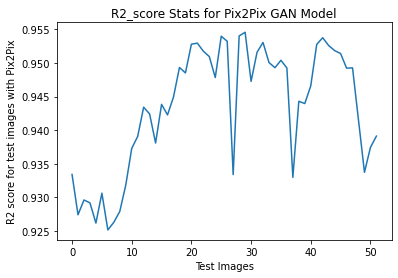

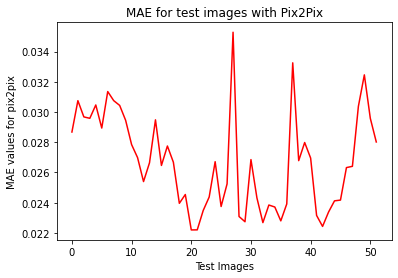

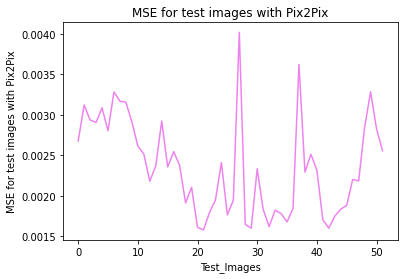

In [ ]:
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
# testing all the images
import matplotlib.pyplot as plt
def plot_images(src_img, gen_img, tar_img):
  images = [src_img,gen_img, tar_img]
  #images = vstack((src_img,gen_img, tar_img))
  #scale from [-1,1] to [0,1]
  #images = (images +1)/2.0
  titles = ['Source','Generated','Expected']
  #plot images row by
  # matplotlib.image.imsave("Generated_img.jpg",images[1])
  # matplotlib.image.imsave("Target_img.jpg",images[2])
  f, axarr = plt.subplots(1,3, figsize=(10,15))
  for i in range(len(images)):
    #define subplot
    pos = axarr[i].imshow(images[i].reshape(192,128), cmap = "rainbow", interpolation = 'None')
    cax = f.add_axes([axarr[i].get_position().x1+0.01,axarr[i].get_position().y0,0.02,axarr[i].get_position().height])
    f.colorbar(pos, ax = axarr[i], cax =cax)
    # pyplot.subplot(1,3,1+i)
    # #turn off acis
    # pyplot.axis('off')
    # #plot raw pixel data
    # pyplot.imshow(images[i].reshape(512,512))
    # #show title
    axarr[i].set_title(titles[i])
  pyplot.show()

# load dataset
# load and prepare training images

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_test_AVHRR_data.npz')
[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
print('Loaded', X1.shape, X2.shape)
# load model
#model = load_model('/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/model_030000.h5')
model = load_model('/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_3_bcdunet/model_003000.h5')
original = []
predicted = []
predicted_unscaled_without_colorcode =[]
R2_score_avhrr_model_015000 =[]
mae_avhrr_model_015000=[]
mse_avhrr_model_015000=[]
for ix in range(len(X1)):
  ix = np.asarray([ix])
  src_image, tar_image = X1[ix], X2[ix]
  # generate image from source
  gen_image = model.predict(src_image)
  generated = unscale(gen_image,VHI_test[int(ix)+1])
  #print("The generated image array through gan is: \n", generated)
  # real input
  real = unscale(X1[ix], VHI_test[int(ix)])
  #plt.imshow(real)
  #expected
  expected = unscale(X2[ix],VHI_test[int(ix)+1])
  #print("\n The expected output was: \n",expected)
  #generated
  yreal = tar_image.reshape(192,128)
  pred = gen_image.reshape(192,128)
  r2 = r2_score(yreal, pred)
  res = mae(yreal, pred)
  error = mse(yreal, pred)
  test_gen = colorcoding(generated)
  test_real = colorcoding(real)
  #plt.imshow(test_gen)
  # plot all three images
  test_im = colorcoding(expected)
  R2_score_avhrr_model_015000.append(r2)
  mae_avhrr_model_015000.append(res)
  mse_avhrr_model_015000.append(error)
  predicted_unscaled_without_colorcode.append(pred.reshape(192,128))
  original.append(test_im)
  predicted.append(test_gen)
  np.save("/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_2_bcdunet/R2_score_avhrr_model_012414.npy", R2_score_avhrr_model_015000)
  np.save("/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_2_bcdunet/mae_avhrr_model_012414.npy", mae_avhrr_model_015000)
  np.save("/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_2_bcdunet/mse_avhrr_model_012414.npy", mse_avhrr_model_015000)
  np.save("/content/drive/MyDrive/Drought_Dataset/Output_files_gan_lstm/model_2_bcdunet/predicted_unscaled_without_colorcoded_model_012414.npy", predicted_unscaled_without_colorcode)
  test_gen = np.reshape(test_gen,(256,256,1))
  test_im = np.reshape(test_im,(256,256,1))
  test_real = np.reshape(test_real,(256,256,1))
  plt.imshow(test_im)
  plot_images(test_real, test_gen, test_im)

In [ ]:
np.max(R2_score_avhrr_model_015000),R2_score_avhrr_model_015000[49:52], mae_avhrr_model_015000[49:52], mse_avhrr_model_015000[49:52]

(0.9545797391654829,
 [0.9337437081186417, 0.9374488188631205, 0.9391295855686951],
 [0.03245858, 0.029582288, 0.028017156],
 [0.0032855382, 0.002825532, 0.0025561382])

In [ ]:
np.mean(R2_score_avhrr_model_015000)

0.9433503021327989

In [ ]:
import os
path = r"/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/"
dir_list = os.listdir(path)
for file in dir_list:
    if file.endswith(".h5"):
      print(os.path.join(path,file))

/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_001000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_002000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_003000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_004000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_005000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_006000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_007000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_008000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_009000.h5
/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_c

In [ ]:
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy.random import randint

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_test_AVHRR_data.npz')
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
[X1,X2] = load_real_samples("/Users/Jyoti_Shukla/Documents/Jyoti/Karnataka Dataset/paired_padded_arrays_test_total_AVHRR_data.npz")
print('Loaded', X1.shape, X2.shape)
# load model
#model = load_model('/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/model_030000.h5')
for file in dir_list:
    if file.endswith(".h5"):
      model = load_model(os.path.join(path,file))
      prediction = model.predict(X1)
      # original = []
      # predicted = []
      # predicted_unscaled_without_colorcode =[]
      R2_score_avhrr_model_015000 =[]
      mae_avhrr_model_015000=[]
      mse_avhrr_model_015000=[]
      for ix in range(len(X1)):
        # ix = np.asarray([ix])
        src_image, tar_image = X1[ix], X2[ix]
        # # generate image from source
        # gen_image = model.predict(src_image)
        # generated = unscale(gen_image,VHI_test[int(ix)+1])
        #print("The generated image array through gan is: \n", generated)
        # real input
        # real = unscale(X1[ix], VHI_test[int(ix)])
        #plt.imshow(real)
        #expected
        # expected = unscale(X2[ix],VHI_test[int(ix)+1])
        #print("\n The expected output was: \n",expected)
        #generated
        yreal = tar_image.reshape(192,128)
        pred = prediction[ix].reshape(192,128)
        r2 = r2_score(yreal, pred)
        res = mae(yreal, pred)
        error = mse(yreal, pred)
        # test_gen = colorcoding(generated)
        # test_real = colorcoding(real)
        #plt.imshow(test_gen)
        # plot all three images
        # test_im = colorcoding(expected)
        R2_score_avhrr_model_015000.append(r2)
        mae_avhrr_model_015000.append(res)
        mse_avhrr_model_015000.append(error)
        # predicted_unscaled_without_colorcode.append(pred.reshape(192,128))

      print("For model", file[7:-3], "mean R2 is:", np.mean(R2_score_avhrr_model_015000) )
      print("For model", file[7:-3], "max R2 is:", np.max(R2_score_avhrr_model_015000))
      print("For model", file[7:-3], "mean mse is:", np.mean(mse_avhrr_model_015000))
      print("For model", file[7:-3], "mean mae is:", np.mean(mae_avhrr_model_015000))




Loaded (52, 192, 128, 1) (52, 192, 128, 1)
For model 01000 mean R2 is: 0.8852195556188763
For model 01000 max R2 is: 0.9131498248667317
For model 01000 mean mse is: 0.007878072
For model 01000 mean mae is: 0.053811695
For model 02000 mean R2 is: 0.9268112384578997
For model 02000 max R2 is: 0.9376755724761728
For model 02000 mean mse is: 0.0041274275
For model 02000 mean mae is: 0.03732934
For model 03000 mean R2 is: 0.9306847925077608
For model 03000 max R2 is: 0.9413045300708498
For model 03000 mean mse is: 0.0034954424
For model 03000 mean mae is: 0.033436984
For model 04000 mean R2 is: 0.936412655522636
For model 04000 max R2 is: 0.9457247872014857
For model 04000 mean mse is: 0.0030664233
For model 04000 mean mae is: 0.031458143
For model 05000 mean R2 is: 0.9380772529172566
For model 05000 max R2 is: 0.9492235908353049
For model 05000 mean mse is: 0.0029286162
For model 05000 mean mae is: 0.030743463
For model 06000 mean R2 is: 0.9364202567440871
For model 06000 max R2 is: 0.9483

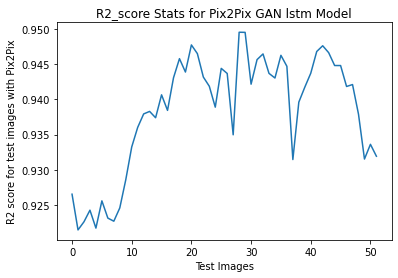

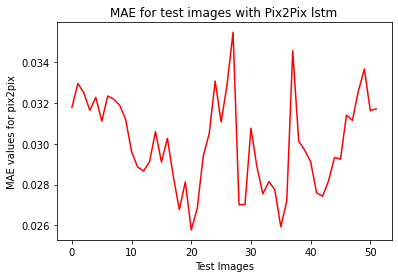

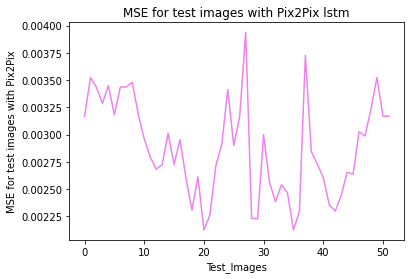

In [ ]:
plt.plot(R2_score_avhrr_model_015000)
plt.xlabel("Test Images")
plt.ylabel("R2 score for test images with Pix2Pix")
plt.title("R2_score Stats for Pix2Pix GAN lstm Model")
plt.show()
plt.plot(mae_avhrr_model_015000,'r')
plt.xlabel("Test Images")
plt.ylabel("MAE values for pix2pix")
plt.title("MAE for test images with Pix2Pix lstm")
plt.show()
plt.plot(mse_avhrr_model_015000,'violet')
plt.xlabel("Test_Images")
plt.ylabel("MSE for test images with Pix2Pix")
plt.title("MSE for test images with Pix2Pix lstm")
plt.show()

In [ ]:
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy.random import randint
import numpy as np

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
[X1, X2] = load_real_samples('/Users/Jyoti_Shukla/Documents/Jyoti/Karnataka Dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_020000.h5')
predicted = model.predict(X1)
np.save("/Users/Jyoti_Shukla/Documents/Jyoti/pix2pix_outputs_total/model_2_avhrr_complete_steps/model_020000_predicted_avhrr_total.npy", predicted)

Loaded (52, 192, 128, 1) (52, 192, 128, 1)


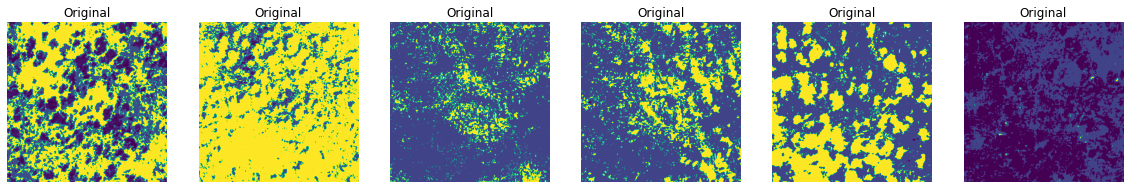

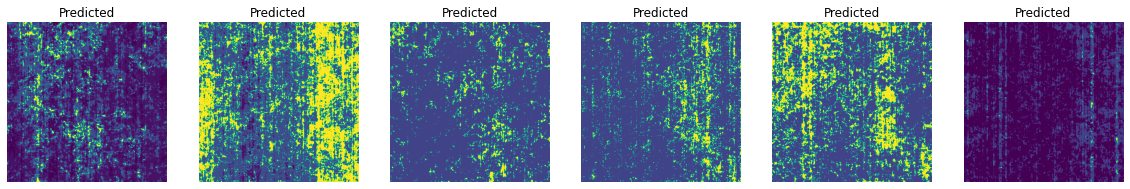

In [ ]:
#@title
titles = ['Original','Predicted']
images = np.vstack((original,predicted))
plt.figure(figsize=(20,20))
for i in range(len(original)-5):
    #define subplot
    pyplot.subplot(1,6,1+i)
    #turn off acis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(original[i].reshape(512,512))
    #show title
    pyplot.title(titles[0])

pyplot.show()
plt.figure(figsize=(20,20))
for i in range(len(original)-5):
    #define subplot
    pyplot.subplot(1,6,1+i)
    #turn off acis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(predicted[i].reshape(512,512))
    #show title
    pyplot.title(titles[1])

pyplot.show()



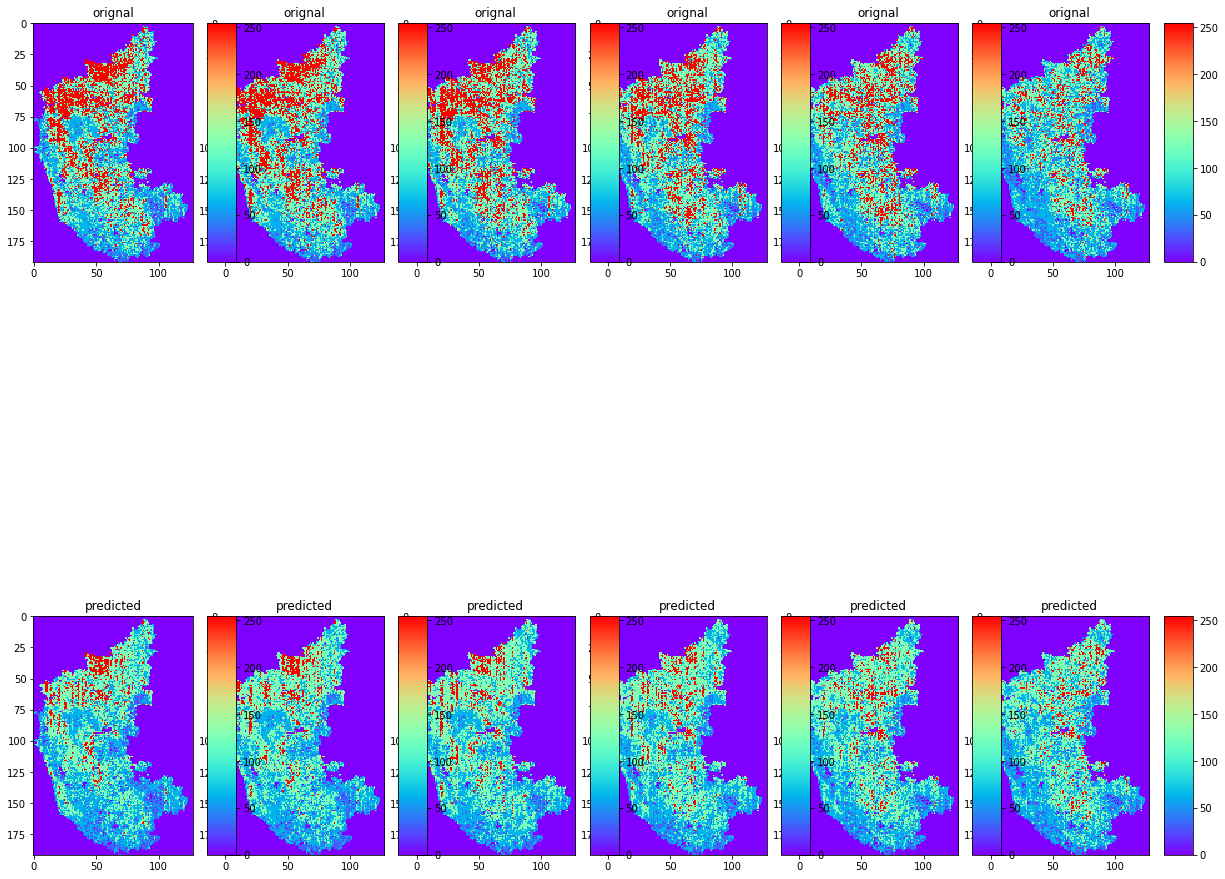

In [ ]:
f, axarr = plt.subplots(2,6, figsize=(20,20))
#axarr = axarr.ravel()

for i in range(2):
   for j in range(6):
     #print(i,j)
     if i == 0:
       pos= axarr[i,j].imshow(original[j],cmap='rainbow',interpolation='None')
       axarr[i,j].set_title('orignal')
       cax = f.add_axes([axarr[i,j].get_position().x1+0.01,axarr[i,j].get_position().y0,0.02,axarr[i,j].get_position().height])
       f.colorbar(pos, ax=axarr[i,j], cax= cax)
     else:
       neg= axarr[i,j].imshow(predicted[j], cmap='rainbow', interpolation='None')
       axarr[i,j].set_title('predicted')
       cax = f.add_axes([axarr[i,j].get_position().x1+0.01,axarr[i,j].get_position().y0,0.02,axarr[i,j].get_position().height])
       f.colorbar(neg, ax=axarr[i,j], cax= cax)
plt.show()

# **Inference and conclusion**

1. With MSE as the loss in place of MAE, the best model seems to be on 6930th epoch. the differences are around 1 between generated and original values. however, the visible outcomes are not satisfactory.

2. With Huber loss, del=0.5, the outputs and values are slightly improved but not much. Output better on multiple epochs; decide according to output results.

3. Attempting to change the model slightly with deleting two 512 layers of encoder and decoder so as to reduce further division of input dimension and keeping the filter size of last output layer of transposed convolution layer as (4,4) instead of (8,8).



## BDCU_net_D3

Implement this generator architecture instead of priorly defined encoder-decoder architecture
https://github.com/rezazad68/BCDU-Net/tree/master

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import *
from keras.layers import *
import numpy as np

In [ ]:
def define_generator(input_size = (192,128,1)):
    N1 = input_size[0]
    N2 = input_size[1]
    init = RandomNormal(stddev=0.02)
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(pool3)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(drop4_1)
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(merge_dense)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = init)(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N1/4), np.int32(N2/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N1/4), np.int32(N2/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = init )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = init)(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N1/2), np.int32(N2/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N1/2), np.int32(N2/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = init )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = init)(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N1, N2, 64))(conv1)
    x2 = Reshape(target_shape=(1, N1, N2, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = init )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = init)(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    huber_loss = tf.keras.losses.Huber(delta = 0.5)
    model.compile(optimizer = 'sgd', loss = 'mse', metrics = ['mse'])
    return model

In [ ]:
mod = BCDU_net_D3(image_shape)